<a href="https://colab.research.google.com/github/jpadolina/Instacart_Analysis/blob/main/InstacartComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Instacart Segmentation Project

# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import scoreatpercentile
import seaborn as sns
import math
import sklearn.preprocessing as skp
import sklearn.cluster as skc
import sklearn.metrics as skm
from sklearn.manifold import TSNE
color = sns.color_palette()

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# Change directory to the right drive
%cd '/content/drive/MyDrive/Kaggle'

/content/drive/.shortcut-targets-by-id/1Yh_wINgfF37gzjnJsQ0a6Q8-cn_B1b4c/Kaggle


In [5]:
# Load data
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
orders_prior = pd.read_csv("order_products__prior.csv")
orders_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [6]:
orders_prior.shape

(32434489, 4)

In [7]:
# Concatenate orders_prior and orders_train
orders_products = pd.concat([orders_prior,orders_train])

In [8]:
orders_products.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
orders_products.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


# Exploratory Data Analysis (EDA)

## Products per Order

In [10]:
orders_products.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [11]:
# Make a counts table to visualize # products per order
product_counts = orders_products.groupby('order_id').count()

In [12]:
product_counts.head(10)

,product_id,add_to_cart_order,reordered
order_id,,,
1,8,8,8
2,9,9,9
3,8,8,8
4,13,13,13
5,26,26,26
6,3,3,3
7,2,2,2
8,1,1,1
9,15,15,15


In [13]:
products.head(10)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


{'boxes': [<matplotlib.lines.Line2D at 0x7faab0e16bd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7faab0da9c50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7faab0e161d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7faab0db0750>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7faab798bb10>,
  <matplotlib.lines.Line2D at 0x7faab0da9710>]}

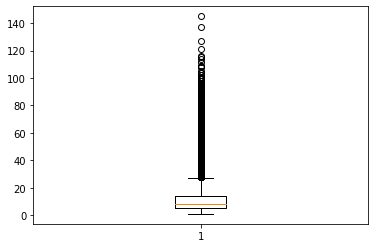

In [14]:
plt.boxplot(product_counts['product_id'])

(array([2.696216e+06, 5.690350e+05, 7.299100e+04, 6.739000e+03,
        8.790000e+02, 1.560000e+02, 4.900000e+01, 1.400000e+01,
        2.000000e+00, 2.000000e+00]),
 array([  1. ,  15.4,  29.8,  44.2,  58.6,  73. ,  87.4, 101.8, 116.2,
        130.6, 145. ]),
 <a list of 10 Patch objects>)

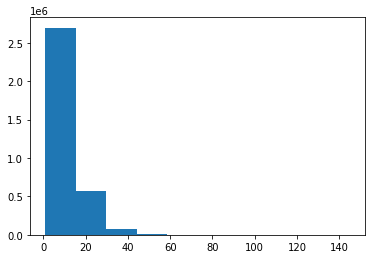

In [15]:
plt.hist(product_counts['product_id'])

In [16]:
# Find the mean products per order
product_counts['product_id'].mean()

10.10707325550502

In [17]:
# Find the mode products per order
product_counts['product_id'].mode()

0    5
dtype: int64

In [18]:
# Find the median products per order
product_counts['product_id'].median()

8.0

In [19]:
# IQR products per order
q1 = scoreatpercentile(product_counts['product_id'],25)
q3 = scoreatpercentile(product_counts['product_id'],75)
[q1,q3]

[5.0, 14.0]

## Products Reordered

In [20]:
# Find percentage of orders that had reordered products
orders_with_re = orders_products.groupby('order_id')['reordered'].sum()
orders_with_re.head(5)

order_id
1     4
2     6
3     8
4    12
5    21
Name: reordered, dtype: int64

In [21]:
(len(orders_with_re)-len(orders_with_re[orders_with_re == 0]))/len(orders_with_re)

0.8813194412690899

In [22]:
# Find number of times each product has been reordered
reordered_products = orders_products.groupby('product_id')['reordered'].sum()

In [23]:
reordered_products.head(10)

product_id
1     1185
2       13
3      209
4      161
5       10
6        3
7       13
8       90
9       84
10    1374
Name: reordered, dtype: int64

In [24]:
# Find the most reordered products
reordered_productsname = pd.merge(reordered_products, products, on = 'product_id', how = 'left')

In [25]:
reordered_productsname.sort_values('reordered',ascending=False).head(10)

,product_id,reordered,product_name,aisle_id,department_id
24849,24852,415166,Banana,24,4
13173,13176,329275,Bag of Organic Bananas,24,4
21134,21137,214448,Organic Strawberries,24,4
21900,21903,194939,Organic Baby Spinach,123,4
47205,47209,176173,Organic Hass Avocado,24,4
47762,47766,140270,Organic Avocado,24,4
27842,27845,118684,Organic Whole Milk,84,16
47622,47626,112178,Large Lemon,24,4
27963,27966,109688,Organic Raspberries,123,4
16794,16797,104588,Strawberries,24,4


Main findings of orders_products table
1. IQR (75%) of number products per order is 5-14 products.
2. Distribution of number of products per order is right-skewed with a mean of 10.11 and a mode of 5.
3. 88% of orders include reordered products.
4. Select fruits and milk are among the most reordered products.

In [26]:
# Total and average number of products purchased per customer
orders_products_cust = pd.merge(orders_products, orders[['order_id','user_id']],on = 'order_id')

In [27]:
cust_products = orders_products_cust.groupby(['user_id'])['product_id'].count()
orders_per_customer = orders_products_cust.groupby(['user_id'])['order_id'].nunique()

In [28]:
orders_products_cust.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id
0,2,33120,1,1,202279
1,2,28985,2,1,202279
2,2,9327,3,0,202279
3,2,45918,4,1,202279
4,2,30035,5,0,202279
5,2,17794,6,1,202279
6,2,40141,7,1,202279
7,2,1819,8,1,202279
8,2,43668,9,0,202279
9,3,33754,1,1,205970


## Products

In [29]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [30]:
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [31]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faaafd57190>]],
      dtype=object)

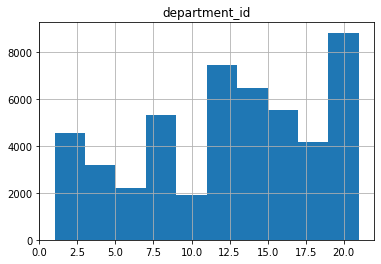

In [32]:
products.hist(column = 'department_id')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faab0d89fd0>]],
      dtype=object)

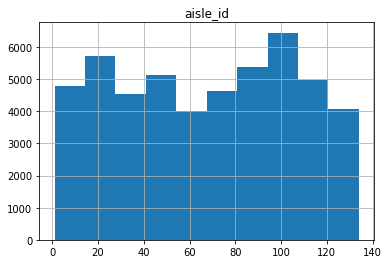

In [33]:
products.hist(column='aisle_id')

In [34]:
prod_dept = pd.merge(products, departments, on = 'department_id', how = 'left')
prod_dept.head()

,product_id,product_name,aisle_id,department_id,department
0,1,Chocolate Sandwich Cookies,61,19,snacks
1,2,All-Seasons Salt,104,13,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen
4,5,Green Chile Anytime Sauce,5,13,pantry


In [35]:
prod_dept_aisle = pd.merge(prod_dept, aisles, on = 'aisle_id', how = 'left')
prod_dept_aisle.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


What are the most common aisles and departments? Note: these are what the supermarket offers, not what is ordered.

In [36]:
cnt_aisle = prod_dept_aisle['aisle'].value_counts().reset_index().head(20)
cnt_aisle.columns = ['aisle', 'count']
cnt_aisle

,aisle,count
0,missing,1258
1,candy chocolate,1246
2,ice cream ice,1091
3,vitamins supplements,1038
4,yogurt,1026
5,chips pretzels,989
6,tea,894
7,packaged cheese,891
8,frozen meals,880
9,cookies cakes,874


In [37]:
cnt_dept = prod_dept_aisle['department'].value_counts().reset_index()
cnt_dept.columns = ['department', 'count']
cnt_dept

,department,count
0,personal care,6563
1,snacks,6264
2,pantry,5371
3,beverages,4365
4,frozen,4007
5,dairy eggs,3449
6,household,3085
7,canned goods,2092
8,dry goods pasta,1858
9,produce,1684


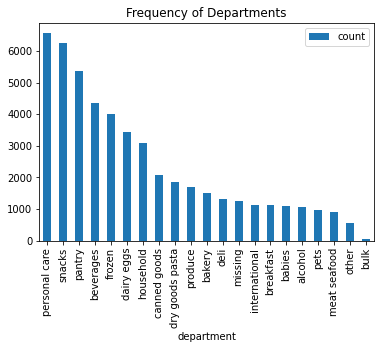

In [38]:
cnt_dept.plot.bar(x = 'department', y = 'count', title = "Frequency of Departments")

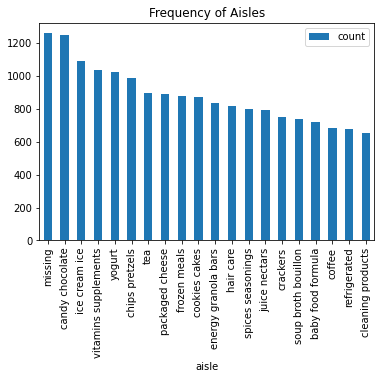

In [39]:
cnt_aisle.plot.bar(x = 'aisle', y = 'count', title = "Frequency of Aisles")

Takeaways:


*   1258 products have aisle of 'missing'
*   The personal care, snacks, and pantry departments have the most items
*   The candy chocolate, ice cream ice, and vitamin supplements aisles have the most product variety



## Orders

In [40]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [41]:
orders['days_since_prior_order'].describe()

count    3.214874e+06
mean     1.111484e+01
std      9.206737e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

In [42]:
## check if there is any null value in Orders table
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

### Order Time Exploration

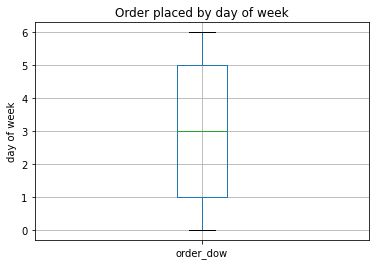

In [43]:
## Check at which day of week do customer place orders
## Most of the orders are placed at day 3 (Wednesday)
orders.boxplot('order_dow')
plt.title('Order placed by day of week')
plt.ylabel('day of week')
plt.show()

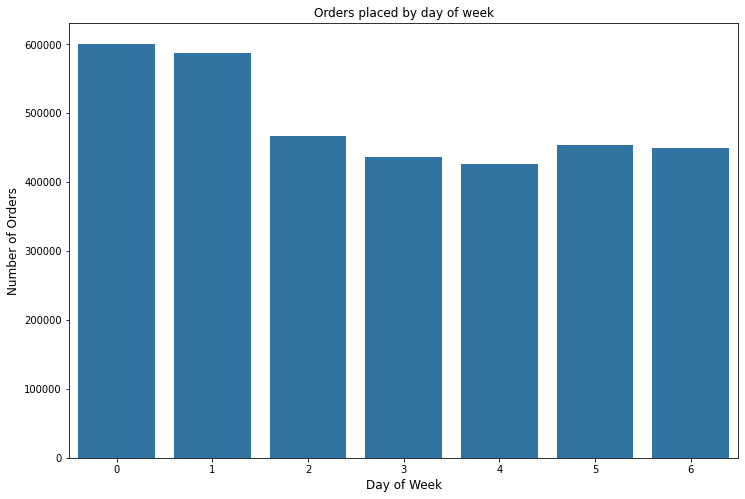

In [44]:
# code borrowed from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart
plt.figure(figsize=(12,8))
sns.countplot(x = "order_dow", data = orders, color = color[0])
plt.ylabel('Number of Orders', fontsize = 12)
plt.xlabel('Day of Week', fontsize=12)
plt.title("Orders placed by day of week")
plt.show()

More orders are placed on days 0 and 1, which could represent the weekend.

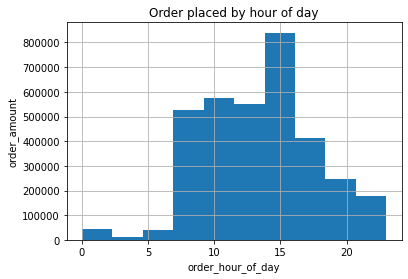

In [45]:
## Check at what time do customers order the most
## Most of the people place orders around 14:00 - 16:00
orders.hist(column='order_hour_of_day')
plt.title('Order placed by hour of day')
plt.xlabel('order_hour_of_day')
plt.ylabel('order_amount')
plt.show()

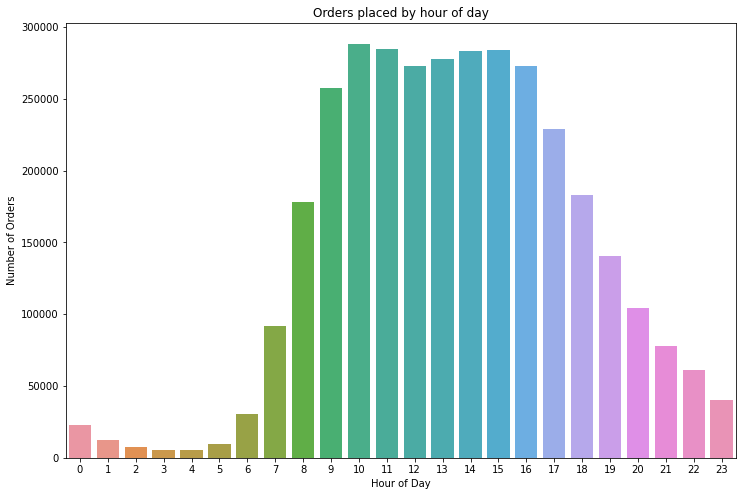

In [46]:
# code borrowed from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart
plt.figure(figsize=(12,8))
sns.countplot(x = 'order_hour_of_day', data = orders)
plt.ylabel('Number of Orders')
plt.xlabel('Hour of Day')
plt.title('Orders placed by hour of day')
plt.show()

Most of the orders are placed between 9am and 4pm.

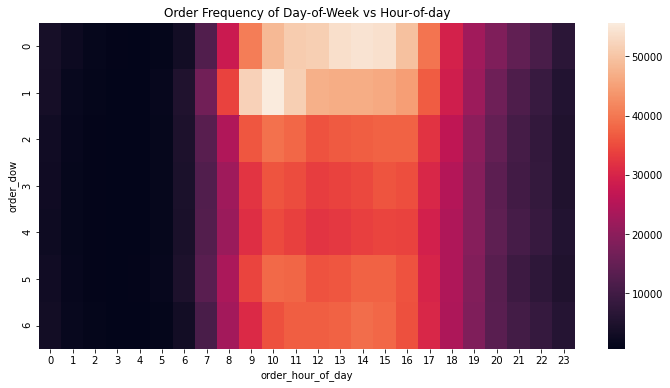

In [47]:
## Create a heat map to see Order Frequency of Day-of-Week vs Hour-of-day
grouped_orders = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_orders = grouped_orders.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_orders)
plt.title("Order Frequency of Day-of-Week vs Hour-of-day")
plt.show()

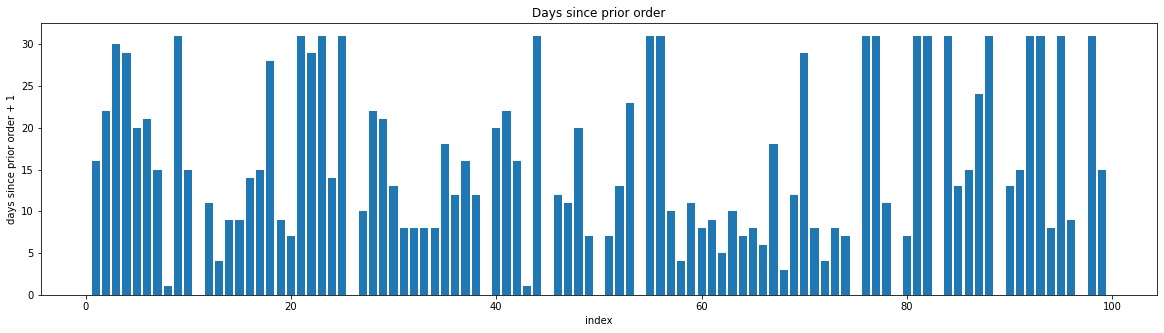

In [48]:
## Check how many days later customers returned after making the last purchase (only using the first 100 purchase or)
## This is code is referred to one of the Kaggle competition participants: https://www.kaggle.com/katharinepires/association-rules-instacart-market-basket-analysis
plt.figure(figsize = (20,5))
plt.bar(range(100), orders.days_since_prior_order[:100] + 1)
plt.title('Days since prior order')
plt.xlabel('index')
plt.ylabel('days since prior order + 1');

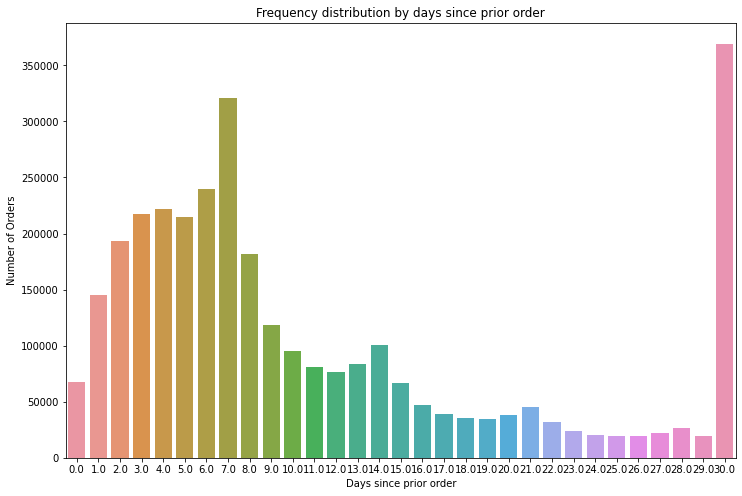

In [49]:
# code borrowed from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart
plt.figure(figsize=(12,8))
sns.countplot(x = 'days_since_prior_order', data = orders)
plt.ylabel("Number of Orders")
plt.xlabel('Days since prior order')
plt.title("Frequency distribution by days since prior order")
plt.show()

There appear to be two spikes: at the 7 day and 30 day mark which shows that customers typically reorder at the end of the week or end of the month.

### Train Test Split

In [50]:
## Notice that the data has already been splitted into train and test data sets
## There are 206209 customers in total, 131209 of which are used for train data and 75000 of which are used as test data set
user_counts = orders.groupby('eval_set')['user_id'].count()
user_counts

eval_set
prior    3214874
test       75000
train     131209
Name: user_id, dtype: int64

## Takeaways
1. Most of the people place orders around 14:00 - 16:00
2. Most of the people place orders around day 3 (Wednesday)
3. Lots of missing data in day since last orders
    * interpretation: lots of users are new users/data collection problems


## Orders per customer

In [51]:
orders_per_cust = orders.groupby('user_id')['order_number'].count()
orders_per_cust.head(10)

user_id
1     11
2     15
3     13
4      6
5      5
6      4
7     21
8      4
9      4
10     6
Name: order_number, dtype: int64

In [52]:
orders_per_cust.describe()

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_number, dtype: float64

## Next Steps
Feature Scaling and model building 
* Thoughts:
Time series modeling?

### Segmentation thoughts
1. By Recency 
2. By Frquency
3. Average products per order
4. We might divide at by department level

# RFMP Analysis

By identifying customers' order recency, frequency, total products ordered, and product preferences, we can develop an analysis used to cluster customers into distinct segments. We can then use the segments for modeling.

R - Recency

F - Frequency

M - Monetary Value (we lack this variable and so we'll substitute it with total products ordered)

P - Product preferences determined by order composition by product category

## Build RFM dataframe

In [53]:
# Verify that all NaN values in days_since_prior_order are associated with customers' first orders in period (order_number = 1)
orders['order_number'][orders['days_since_prior_order'].isnull()].unique()

array([1])

In [54]:
# Find each customer's recency
# Recency will be measured by the average value of 'days_since_prior_order'
recency = orders.groupby(['user_id'])['days_since_prior_order'].mean()
recency.head(10)

user_id
1     19.000000
2     16.285714
3     12.000000
4     17.000000
5     11.500000
6     13.333333
7     10.450000
8     23.333333
9     22.000000
10    21.800000
Name: days_since_prior_order, dtype: float64

In [55]:
# Frequency = total orders per customer
frequency = orders_per_cust

In [56]:
# Find total products ordered per customer
total_products = orders_products_cust.groupby('user_id').count()
total_products.head(10)

,order_id,product_id,add_to_cart_order,reordered
user_id,,,,
1,70,70,70,70
2,226,226,226,226
3,88,88,88,88
4,18,18,18,18
5,46,46,46,46
6,14,14,14,14
7,215,215,215,215
8,67,67,67,67
9,98,98,98,98


In [57]:
orders_products_cust.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id
0,2,33120,1,1,202279
1,2,28985,2,1,202279
2,2,9327,3,0,202279
3,2,45918,4,1,202279
4,2,30035,5,0,202279
5,2,17794,6,1,202279
6,2,40141,7,1,202279
7,2,1819,8,1,202279
8,2,43668,9,0,202279
9,3,33754,1,1,205970


In [58]:
prod_dept_aisle.head(10)

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation
5,6,Dry Nose Oil,11,11,personal care,cold flu allergy
6,7,Pure Coconut Water With Orange,98,7,beverages,juice nectars
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen,frozen produce
8,9,Light Strawberry Blueberry Yogurt,120,16,dairy eggs,yogurt
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,beverages,water seltzer sparkling water


## Categorize products into 3 major groups according to department

In [59]:
prod_dept_aisle['department'].unique()

array(['snacks', 'pantry', 'beverages', 'frozen', 'personal care',
       'dairy eggs', 'household', 'babies', 'meat seafood',
       'dry goods pasta', 'pets', 'breakfast', 'canned goods', 'produce',
       'missing', 'international', 'deli', 'alcohol', 'bakery', 'other',
       'bulk'], dtype=object)

Product group 1: Perishable goods (frozen, dairy eggs, meat seafood, produce, deli, bakery

Product group 2: Shelf-stable goods (snacks, pantry, beverages, dry goods pasta, breakfast, canned goods, alcohol, bulk, international)

Product group 3: Non-edible items (personal care, household, babies, pets, missing, other)

In [60]:
pg1 = ['frozen','dairy eggs','meat seafood','produce','deli','bakery']
pg2 = ['snacks','pantry','beverages','dry goods pasta','breakfast','canned goods','alcohol','bulk','international']
pg3 = ['personal care','household','babies','pets','missing','other']

In [61]:
prod_dept_aisle['pg1'] = np.where(prod_dept_aisle['department'].isin(pg1), 1, 0)
prod_dept_aisle['pg2'] = np.where(prod_dept_aisle['department'].isin(pg2), 1, 0)
prod_dept_aisle['pg3'] = np.where(prod_dept_aisle['department'].isin(pg3), 1, 0)

In [62]:
prod_dept_aisle.head(10)

,product_id,product_name,aisle_id,department_id,department,aisle,pg1,pg2,pg3
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes,0,1,0
1,2,All-Seasons Salt,104,13,pantry,spices seasonings,0,1,0
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea,0,1,0
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals,1,0,0
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation,0,1,0
5,6,Dry Nose Oil,11,11,personal care,cold flu allergy,0,0,1
6,7,Pure Coconut Water With Orange,98,7,beverages,juice nectars,0,1,0
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen,frozen produce,1,0,0
8,9,Light Strawberry Blueberry Yogurt,120,16,dairy eggs,yogurt,1,0,0
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,beverages,water seltzer sparkling water,0,1,0


In [63]:
# Insert product group columns into orders_products_cust
orders_products_cust = orders_products_cust.merge(prod_dept_aisle[['product_id','pg1','pg2','pg3']], on = ['product_id'])

In [64]:
orders_products_cust.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,pg1,pg2,pg3
0,2,33120,1,1,202279,1,0,0
1,26,33120,5,0,153404,1,0,0
2,120,33120,13,0,23750,1,0,0
3,327,33120,5,1,58707,1,0,0
4,390,33120,28,1,166654,1,0,0
5,537,33120,2,1,180135,1,0,0
6,582,33120,7,1,193223,1,0,0
7,608,33120,5,1,91030,1,0,0
8,623,33120,1,1,37804,1,0,0
9,689,33120,4,1,108932,1,0,0


In [65]:
# Add up counts of each group for each customer
pgcounts = orders_products_cust.groupby('user_id').agg({'pg1': ['sum'], 'pg2': ['sum'], 'pg3': ['sum']})
pgcounts = pgcounts.merge(total_products[['product_id']], on = ['user_id'])

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [66]:
pgcounts.head(10)

,"(pg1, sum)","(pg2, sum)","(pg3, sum)",product_id
user_id,,,,
1,22,45,3,70
2,147,77,2,226
3,67,20,1,88
4,9,7,2,18
5,35,10,1,46
6,10,4,0,14
7,122,91,2,215
8,55,12,0,67
9,57,34,7,98


In [67]:
pgprop = pd.DataFrame(index=pgcounts.index,columns=['pg1','pg2','pg3'])

In [68]:
# Make a dataframe showing the composition of each customer's order habits by product group
for i in range(0,3):
  pgprop.iloc[:,i] = pgcounts.iloc[:,i]/pgcounts.iloc[:,3]

In [69]:
pgprop.head(10)

,pg1,pg2,pg3
user_id,,,
1,0.314286,0.642857,0.042857
2,0.650442,0.340708,0.008850
3,0.761364,0.227273,0.011364
4,0.500000,0.388889,0.111111
5,0.760870,0.217391,0.021739
6,0.714286,0.285714,0.000000
7,0.567442,0.423256,0.009302
8,0.820896,0.179104,0.000000
9,0.581633,0.346939,0.071429


## Build and process RFMP dataframe

Check for skewness, log-transform, and standardize data

In [70]:
# Combine recency, frequency, product total, and product group proportions into one dataframe for analysis
RFMP = pd.concat([recency,frequency,total_products.iloc[:,0],pgprop], axis = 1, sort = False)
RFMP = RFMP.rename(columns = {'days_since_prior_order':'recency', 'order_number':'frequency','order_id':'product_total'})

In [71]:
## Check for skewness in recency, frequency, and product total
RFMP.shape

(206209, 6)

(array([ 1632., 13695., 27720., 29699., 30259., 28668., 25347., 21452.,
        14540., 13197.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

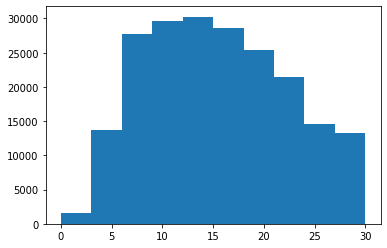

In [72]:
plt.hist(RFMP['recency'])

(array([125516.,  38194.,  16176.,  10120.,   5875.,   4063.,   2184.,
          1252.,    924.,   1905.]),
 array([  4. ,  13.6,  23.2,  32.8,  42.4,  52. ,  61.6,  71.2,  80.8,
         90.4, 100. ]),
 <a list of 10 Patch objects>)

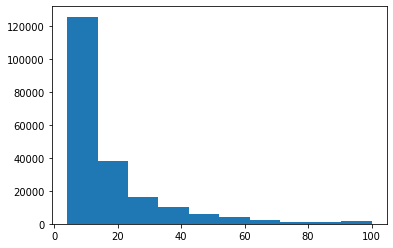

In [73]:
plt.hist(RFMP['frequency'])

(array([1.83933e+05, 1.67550e+04, 4.13400e+03, 1.04700e+03, 2.36000e+02,
        7.00000e+01, 2.30000e+01, 8.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([3.0000e+00, 3.7520e+02, 7.4740e+02, 1.1196e+03, 1.4918e+03,
        1.8640e+03, 2.2362e+03, 2.6084e+03, 2.9806e+03, 3.3528e+03,
        3.7250e+03]),
 <a list of 10 Patch objects>)

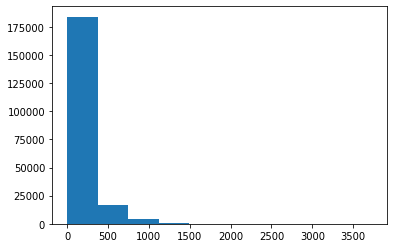

In [74]:
plt.hist(RFMP['product_total'])

(array([ 5143.,  4488.,  7756., 12808., 22864., 40019., 48332., 39532.,
        18939.,  6328.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

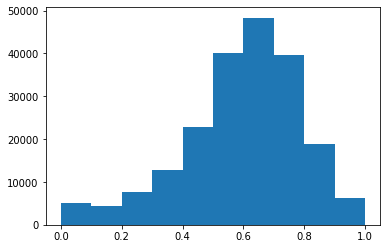

In [75]:
plt.hist(RFMP['pg1'])

(array([ 8847., 27508., 55411., 51930., 31391., 15827.,  6747.,  3558.,
         2533.,  2457.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

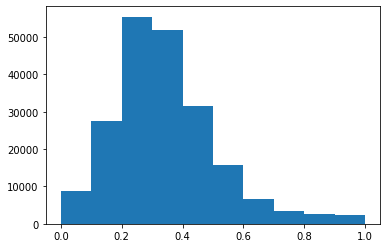

In [76]:
plt.hist(RFMP['pg2'])

(array([166591.,  25368.,   7770.,   2932.,   1384.,    919.,    477.,
           295.,    242.,    231.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

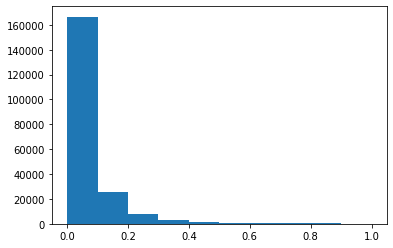

In [77]:
plt.hist(RFMP['pg3'])

Note that Frequency, Product Total, and PG3 (the product group containing non-edible items) are all highly skewed, and the other fields are not. We will transform the skewed fields to scale appropriately and contribute to K-means clustering.

In [78]:
## Log-transform skewed distributions

In [79]:
RFMP['frequency'] = np.log(RFMP['frequency'])
RFMP['product_total'] = np.log(RFMP['product_total'])
RFMP['pg3'] = np.log(RFMP['pg3'])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [80]:
# Convert -inf's in pg3 back to 0
RFMP['pg3'][np.isneginf(RFMP['pg3'])] = 0

(array([43576., 30015., 30922., 26616., 24349., 16674., 14373.,  9883.,
         5886.,  3915.]),
 array([1.38629436, 1.70818194, 2.03006953, 2.35195711, 2.67384469,
        2.99573227, 3.31761986, 3.63950744, 3.96139502, 4.2832826 ,
        4.60517019]),
 <a list of 10 Patch objects>)

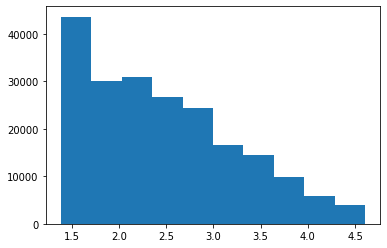

In [81]:
plt.hist(RFMP['frequency'])

(array([ 1423.,  5248., 17074., 37978., 52653., 45297., 29268., 14009.,
         3144.,   115.]),
 array([1.09861229, 1.81103327, 2.52345426, 3.23587524, 3.94829623,
        4.66071721, 5.37313819, 6.08555918, 6.79798016, 7.51040115,
        8.22282213]),
 <a list of 10 Patch objects>)

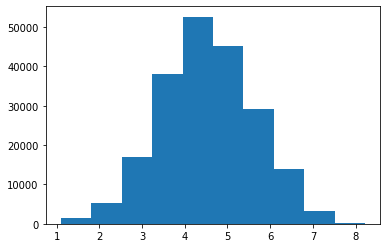

In [82]:
plt.hist(RFMP['product_total'])

(array([2.0000e+01, 3.0900e+02, 2.1890e+03, 8.7760e+03, 2.2754e+04,
        3.8514e+04, 4.0779e+04, 2.8708e+04, 1.0361e+04, 5.3799e+04]),
 array([-7.83794892, -7.05415402, -6.27035913, -5.48656424, -4.70276935,
        -3.91897446, -3.13517957, -2.35138467, -1.56758978, -0.78379489,
         0.        ]),
 <a list of 10 Patch objects>)

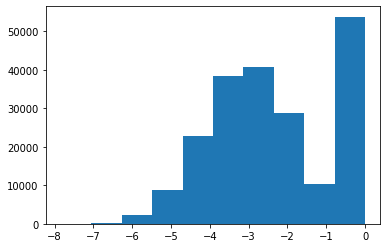

In [83]:
plt.hist(RFMP['pg3'])

The skewness has been reduced and we can proceed with standardizing the data.

In [84]:
## Standardize the data
# This involves scaling and centering so that each column has a mean of 0 and a standard deviation of 1.

In [85]:
scaler = skp.StandardScaler()
RFMP_scaled = skp.scale(RFMP)

In [86]:
RFMP_scaled

array([[ 0.51352523, -0.07034766, -0.25913711, -1.43414068,  1.75192055,
        -0.51934899],
       [ 0.12103549,  0.31679098,  0.82143677,  0.28607854, -0.01305391,
        -1.48555096],
       [-0.49868517,  0.13817101, -0.04815431,  0.85369678, -0.67567461,
        -1.33239785],
       ...,
       [-0.16429423,  0.47302094,  0.8091164 ,  0.17022367,  0.14469335,
        -1.90191012],
       [-1.16857368,  1.8196025 ,  1.83295262,  0.70672951, -0.57958603,
        -0.88390129],
       [ 0.4356629 ,  0.23067336,  0.35994589, -0.42775367,  0.21390834,
         0.055135  ]])

## Find optimal number of clusters

In [87]:
# Define a function that finds the optimal number of clusters using the data's Silhouette Score. Borrowed 
# from https://towardsdatascience.com/the-most-important-data-science-tool-for-market-and-customer-segmentation-c9709ca0b64a

In [88]:
def optimal_kmeans(dataset, start = 2, end = 8):
  ''' 
  We don't anticipate having more than 5 clusters

  INPUT: dataframe to fit k-means, starting range of k means to test, ending range of k means to test
  OUTPUT: values and line plot of silhouette score
  '''

  n_clu = []
  km_ss = []

  #Loop to find optimal n_clusters
  for n_clusters in range(start,end):

    #Create cluster labels
    kmeans = skc.KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(dataset)

    silhouette_avg = round(skm.silhouette_score(dataset, labels, random_state = 1),3)

    #Append score to lists
    km_ss.append(silhouette_avg)
    n_clu.append(n_clusters)

    print("Number of clusters: {}, Silhouette Score: {}, Change from Previous Cluster: {}".format(
        n_clusters, silhouette_avg, (km_ss[n_clusters - start] - km_ss[n_clusters - start - 1]).round(3)))
    
    #Plot graph at the end of the loop
    if n_clusters == end - 1:
      plt.figure(figsize = (6.47,3))
      plt.title('Silhouette Score')
      sns.pointplot(x=n_clu,y=km_ss)
      plt.savefig('silhouette_score.png', format='png',dpi=1000)
      plt.tight_layout()
      plt.show()

    

In [89]:
RFMP_scaled = pd.DataFrame(RFMP_scaled)
RFMP_samp = RFMP_scaled.sample(100000, random_state = 7)

Number of clusters: 2, Silhouette Score: 0.261, Change from Previous Cluster: 0.0
Number of clusters: 3, Silhouette Score: 0.257, Change from Previous Cluster: -0.004
Number of clusters: 4, Silhouette Score: 0.234, Change from Previous Cluster: -0.023
Number of clusters: 5, Silhouette Score: 0.223, Change from Previous Cluster: -0.011
Number of clusters: 6, Silhouette Score: 0.214, Change from Previous Cluster: -0.009
Number of clusters: 7, Silhouette Score: 0.209, Change from Previous Cluster: -0.005


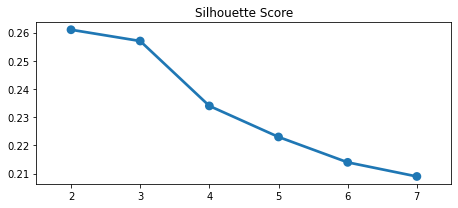

In [90]:
optimal_kmeans(RFMP_samp)

Per the above code, the optimal number of clusters is 7, and perhaps even a higher number, considering we only tested clusters 2-7. For interpretability and simplicity, we will test 5 clusters. 

In [91]:
#Run k-means on 5 clusters

def kmeans(df, clusters_number):
  '''
  Implement k-means clustering on dataset

  INPUT:
    df: dataframe for k-means to fit.
    clusters_number: int. Number of clusters to form.
    end: int. Ending range of kmeans to test.

  OUTPUT: Cluster results and t-SNE vis of clusters
  '''

  kmeans = skc.KMeans(n_clusters = clusters_number, random_state=1)
  kmeans.fit(df)

  # Extract cluster labels
  cluster_labels = kmeans.labels_

  # Create a cluster label column in original dataset
  df_new = df.assign(Cluster = cluster_labels)

  # Initialize TSNE
  model = TSNE(random_state = 7)
  transformed = model.fit_transform(df)

  # Plot t-SNE
  plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
  sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue = cluster_labels,style=cluster_labels,palette="Set1")

  return df_new, cluster_labels

(               0         1         2         3         4         5  Cluster
 41496   0.539816  0.038261 -0.872219  0.084808 -0.542915  0.200815        4
 120710 -1.166844  1.181985 -0.048154  0.737394 -0.476536  1.409915        1
 38747  -0.479405  1.222913  1.336214 -0.982559  0.495967  0.323244        2
 20756   0.682227 -0.634520 -0.007172  0.517431 -0.352435 -0.935080        4
 94950  -0.372159  0.473021  0.149155  0.854230 -0.609904  1.409915        3
 ...          ...       ...       ...       ...       ...       ...      ...
 80974   1.670337 -1.054508 -1.172245  0.106677  0.243427  1.409915        3
 106102 -0.884289  1.541072  0.508772 -2.120687  0.391346  0.863729        2
 102251 -0.787888 -0.467845 -1.137450  1.316753 -1.137873  1.409915        3
 24963   0.947330 -1.333039 -1.285280  0.072447 -0.225448 -0.085992        4
 91857   0.484605 -0.070348  0.449652  0.143173 -0.146397 -0.317334        4
 
 [100000 rows x 7 columns], array([4, 1, 2, ..., 3, 4, 4], dtype=int32))

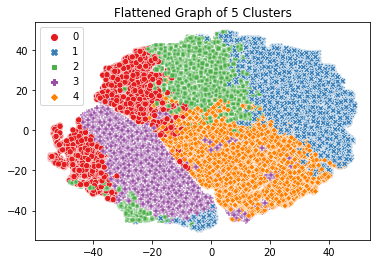

In [92]:
kmeans(RFMP_samp, 5)

The clusters all appear relatively distinct.

Potential use cases: It is possible to build a model using RFMP cluster number to predict the behavior of a new customer. Possible predicted variables include the frequency of purchases, or primary product group that customer is most likely to shop next.

# PCA Analysis

based off of [this](https://www.kaggle.com/asindico/customer-segments-with-pca) Kaggle notebook

In [93]:
prior = orders_prior
train = orders_train

In [94]:
# Reduce amount of data due to RAM
prior = prior[0:300000]

In [95]:
order_prior = pd.merge(prior, orders, on = ['order_id'])
order_prior = order_prior.sort_values(by = ['user_id', 'order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
221645,23391,13198,1,1,7,prior,17,0,10,28.0
221646,23391,42803,2,1,7,prior,17,0,10,28.0
221647,23391,8277,3,1,7,prior,17,0,10,28.0
221648,23391,37602,4,1,7,prior,17,0,10,28.0
221649,23391,40852,5,1,7,prior,17,0,10,28.0


In [96]:
prior_product = pd.merge(prior, products, on = ['product_id'])
prior_prod_order = pd.merge(prior_product, orders, on = ['order_id'])
prior_all = pd.merge(prior_prod_order, aisles, on = ['aisle_id'])
prior_all.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [97]:
# What items customers purchase most frequently
prior_all['product_name'].value_counts()[0:10]

Banana                    4432
Bag of Organic Bananas    3563
Organic Strawberries      2370
Organic Baby Spinach      2242
Organic Hass Avocado      1985
Organic Avocado           1626
Large Lemon               1380
Strawberries              1343
Organic Raspberries       1293
Limes                     1270
Name: product_name, dtype: int64

In [98]:
len(prior_all['product_name'].unique())

24836

In [99]:
len(prior_all['aisle'].unique())

134

In [100]:
prior_all['aisle'].value_counts()[0:10]

fresh fruits                     33755
fresh vegetables                 31004
packaged vegetables fruits       16319
yogurt                           13477
packaged cheese                   9133
milk                              8254
water seltzer sparkling water     7634
chips pretzels                    6581
soy lactosefree                   5965
bread                             5457
Name: aisle, dtype: int64

We have 134 types of products, based on the aisles. Fresh fruits and vegetables are ordered the most often. The only non-perishable items in the top 10 aisles are sparkling water and chips/pretzels.

**Method:**
(from Kaggle notebook) We want to find possible clusters among the different customers and substitute the user's user_id with the cluster to which we assign them. This will eventually increase the prediction model performance. 

In [101]:
# create dataframe with all the purchases made by each user
cust_prod = pd.crosstab(prior_all['user_id'], prior_all['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4
36,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Now we will execute the Principal Component Analysis to this dataframe. According to [this](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) article, principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. The new variables (principle components) are uncorrelated. Most of the information in the initial variables is squeezed or compressed into the first components. PCA tries to put the maximum possible information into the first component, and then the maximum remaining information into the second component and so on.

Principal components are advantageous because they allow you to reduce dimensionality without losing much information by discarding the components with low information and using the primary components in your model. However, principal components are less interpretable and don't have much meaning because they are constructed as linear combinations of the initial variables.

This will reduce the number of features from the number of aisles to 6, the number of principal components we specify below.

In [102]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [103]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-0.286251,1.005868,-1.030293,-0.898974,-0.587609,-0.998766
1,-1.972748,-0.487659,-0.120542,0.213094,0.045947,-0.181994
2,-1.168974,1.284089,3.228124,0.594042,-0.648802,-1.091774
3,-1.433967,1.250081,3.261985,1.237744,-0.353567,-0.346489
4,-2.070709,-0.422148,-0.101552,0.278128,0.005929,-0.097430


Above, we have plotted several pairs of components looking for one suitable for a KMeans Clustering. We have chosen the (PC4,PC1) pair of -2.07.

In [104]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4, 1]])
print(tocluster.shape)
print(tocluster.head())

(25831, 2)
          4         1
0 -0.587609  1.005868
1  0.045947 -0.487659
2 -0.648802  1.284089
3 -0.353567  1.250081
4  0.005929 -0.422148


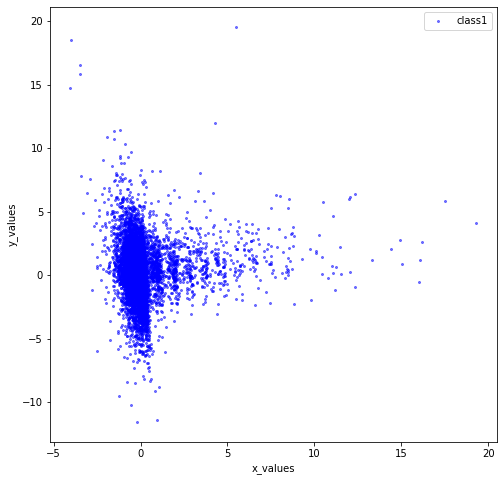

In [105]:
fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color = 'blue', alpha = 0.5, label = 'class1')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [106]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4, random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-0.04624641 -0.15353587]
 [-0.00840694 -2.39821596]
 [-0.24860999  2.06408721]
 [ 5.57233896  1.45511416]]


In [107]:
print(c_preds[0:100])

[2 0 2 2 0 0 0 0 0 0 1 0 2 0 0 3 0 0 2 0 0 0 0 0 0 2 1 0 0 2 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0
 2 2 1 0 0 0 0 0 2 2 0 0 1 2 0 0 0 0 0 2 0 0 2 0 0 0]


['purple', 'orange', 'purple', 'purple', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


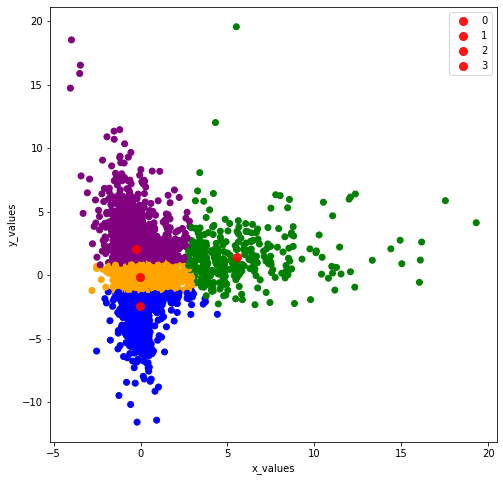

In [108]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange', 'blue', 'purple','green']
colored = [colors[k] for k in c_preds]
print(colored[0:10])
plt.scatter(tocluster[4], tocluster[1], color = colored)
for ci,c in enumerate(centers):
  plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

This plot shows a possible clustering for customers. We will investigate further to see if there is an interesting pattern.

In [109]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,2
27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,2
36,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


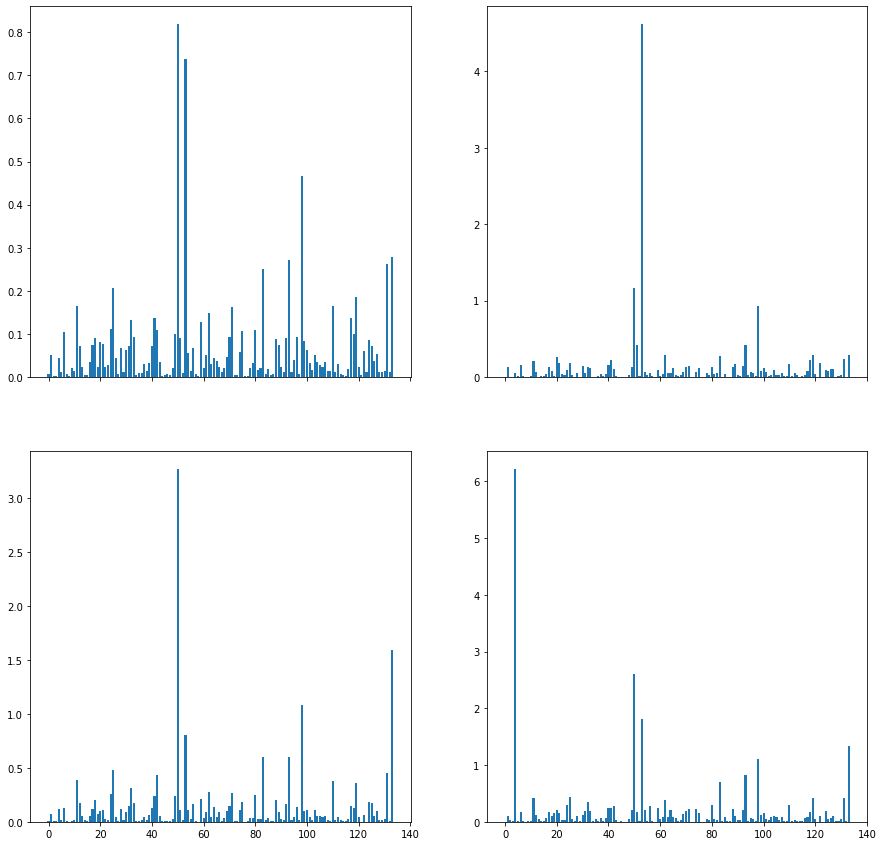

In [110]:
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()

Looking at the top 10 goods bought by people of each cluster.

In [111]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     0.819091
fresh vegetables                 0.738662
packaged vegetables fruits       0.465503
yogurt                           0.278352
packaged cheese                  0.271336
water seltzer sparkling water    0.262774
milk                             0.249903
chips pretzels                   0.205877
soy lactosefree                  0.185660
refrigerated                     0.164669
dtype: float64

In [112]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh vegetables              4.620000
fresh fruits                  1.163448
packaged vegetables fruits    0.923448
packaged cheese               0.423103
fresh herbs                   0.422069
soy lactosefree               0.288966
yogurt                        0.287241
frozen produce                0.283448
milk                          0.279655
canned jarred vegetables      0.262069
dtype: float64

In [113]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     3.270228
yogurt                           1.593429
packaged vegetables fruits       1.078006
fresh vegetables                 0.802414
packaged cheese                  0.603487
milk                             0.597228
chips pretzels                   0.481672
water seltzer sparkling water    0.452839
energy granola bars              0.433169
bread                            0.384220
dtype: float64

In [114]:
c3.sort_values(ascending=False)[0:10]

aisle
baby food formula                6.223164
fresh fruits                     2.604520
fresh vegetables                 1.819209
yogurt                           1.344633
packaged vegetables fruits       1.104520
packaged cheese                  0.830508
milk                             0.697740
chips pretzels                   0.429379
soy lactosefree                  0.420904
water seltzer sparkling water    0.418079
dtype: float64

One interesting observation is that cluster 3 contains people who are likely to buy baby food formula. We will now look to see if clusters differ in quantities and proportions of these goods.

In [115]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'], c0['fresh vegetables'], c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'], c0['water seltzer sparkling water'], c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns=['fresh fruits', 'fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,0.819091,0.738662,0.465503,0.278352,0.271336,0.249903,0.262774,0.205877
1,1.163448,4.620000,0.923448,0.287241,0.423103,0.279655,0.242414,0.188621
2,3.270228,0.802414,1.078006,1.593429,0.603487,0.597228,0.452839,0.481672
3,2.604520,1.819209,1.104520,1.344633,0.830508,0.697740,0.418079,0.429379


In [116]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,24.885040,22.441513,14.142584,8.456684,8.243547,7.592387,7.983419,6.254825
1,14.314200,56.841033,11.361419,3.534004,5.205549,3.440669,2.982478,2.320648
2,36.829784,9.036903,12.140664,17.945426,6.796556,6.726074,5.099935,5.424659
3,28.161271,19.670128,11.942578,14.538790,8.979841,7.544288,4.520464,4.642639


This table shows the pecentage of these goods with resepct to the other top 8 in each cluster. Some observations:

+ Cluster 1 buy more fresh vegetables than other clussters
+ Cluster 2 buy more yogurt than other clusters
+ Cluster 1 includes customers buying more goods than other clusters

Now, we will look at the 10th to 20th most bought products for each cluster to look beyond the generic products (vegetables, fruits, etc.)

In [117]:
c0.sort_values(ascending=False)[10:20]

aisle
bread                  0.164172
ice cream ice          0.163398
frozen produce         0.149423
eggs                   0.137160
soft drinks            0.136662
crackers               0.132851
frozen meals           0.127437
cereal                 0.110700
lunch meat             0.108877
energy granola bars    0.108269
dtype: float64

In [118]:
c1.sort_values(ascending=False)[10:20]

aisle
water seltzer sparkling water    0.242414
eggs                             0.226897
soup broth bouillon              0.226552
bread                            0.213448
chips pretzels                   0.188621
canned meals beans               0.188621
spices seasonings                0.183103
refrigerated                     0.175172
oils vinegars                    0.174828
dry pasta                        0.156897
dtype: float64

In [119]:
c2.sort_values(ascending=False)[10:20]

aisle
refrigerated            0.382208
soy lactosefree         0.361422
crackers                0.308896
frozen produce          0.278274
ice cream ice           0.266652
cereal                  0.261734
lunch meat              0.248771
eggs                    0.240724
fresh dips tapenades    0.235583
frozen meals            0.211891
dtype: float64

In [120]:
c3.sort_values(ascending=False)[10:20]

aisle
bread                  0.415254
frozen produce         0.387006
crackers               0.353107
cereal                 0.302260
refrigerated           0.296610
lunch meat             0.293785
energy granola bars    0.279661
frozen breakfast       0.274011
eggs                   0.242938
frozen meals           0.240113
dtype: float64

Observations:

+ Cluster 2 purchases from the 'soy lactosefree' aisle frequently
+ Cluster 1 contains a lot of unique categories including 'canned meals beans', 'dry pasta', 'oils vinegars', 'spices seasonings', 'soup broth bouillion' which might indicate that this cluster contains home chefs
+ Cluster 0 purchases a lot of foods that are easy to consume, including cereal, lunch meat, frozen meals, and soft drinks
+ We already characterized Cluster 3 by purchasing Baby Food Formula

Now let's look at another possible clustering using the (PC2, PC3) pair.

(25831, 2)
          2         3
0 -1.030293 -0.898974
1 -0.120542  0.213094
2  3.228124  0.594042
3  3.261985  1.237744
4 -0.101552  0.278128


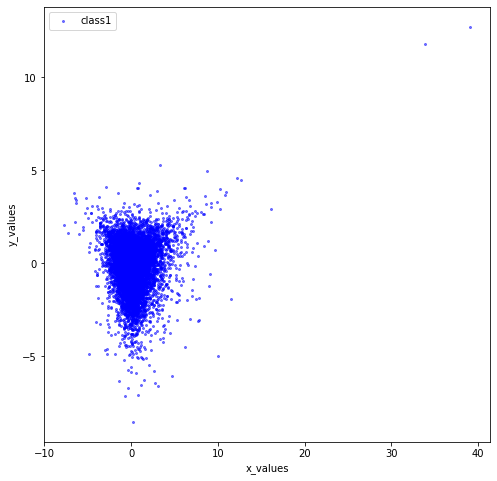

In [121]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[2, 3]])
print(tocluster.shape)
print(tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[2], tocluster[3], 'o', markersize=2, color = 'blue', alpha = 0.5, label = 'class1')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [122]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4, random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)
print(c_preds[0:100])

[[ 0.06593544 -1.41011859]
 [ 0.07732864  0.14496318]
 [-1.14168671  0.57379389]
 [ 2.84352634  0.56510376]]
[0 1 3 3 1 1 1 2 1 3 1 1 2 1 1 0 1 1 2 0 1 0 1 2 2 3 1 1 1 1 1 0 1 0 2 2 1
 2 1 1 0 1 2 1 1 2 1 1 3 1 2 1 1 1 1 1 3 2 1 1 1 1 1 1 2 1 1 1 1 0 1 1 1 0
 2 2 0 0 2 1 1 1 0 0 1 1 1 3 1 2 1 2 1 2 1 1 1 2 1 1]


['orange', 'blue', 'green', 'green', 'blue', 'blue', 'blue', 'purple', 'blue', 'green']


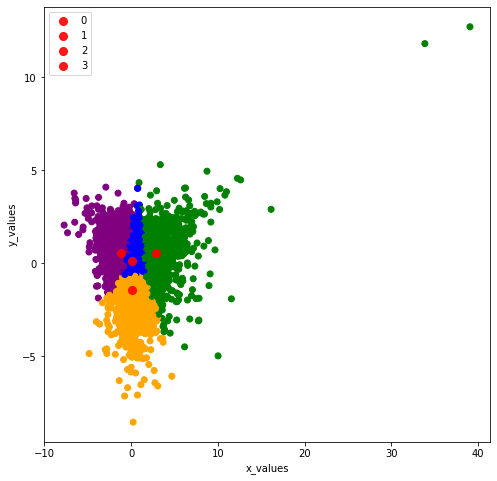

In [123]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange', 'blue', 'purple','green']
colored = [colors[k] for k in c_preds]
print(colored[0:10])
plt.scatter(tocluster[2], tocluster[3], color = colored)
for ci,c in enumerate(centers):
  plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [124]:
clust_prod2 = cust_prod.copy()
clust_prod2['cluster'] = c_preds

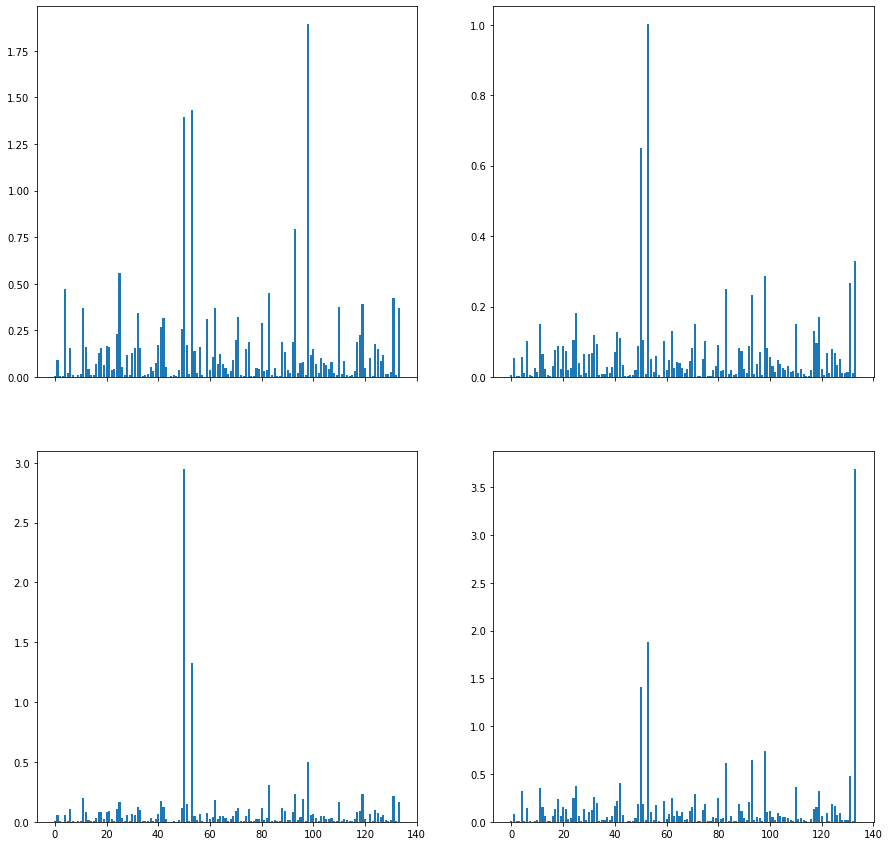

In [125]:
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod2[clust_prod2['cluster']==0])

c0 = clust_prod2[clust_prod2['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod2.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod2[clust_prod2['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod2.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod2[clust_prod2['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod2.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod2[clust_prod2['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod2.drop('cluster',axis=1).columns)),c3)
plt.show()

In [126]:
c0.sort_values(ascending=False)[0:10]

aisle
packaged vegetables fruits       1.893960
fresh vegetables                 1.432227
fresh fruits                     1.393269
packaged cheese                  0.795758
chips pretzels                   0.557861
baby food formula                0.471646
milk                             0.450899
water seltzer sparkling water    0.423698
soy lactosefree                  0.391655
refrigerated                     0.374366
dtype: float64

In [127]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 1.002015
fresh fruits                     0.651080
yogurt                           0.328979
packaged vegetables fruits       0.286876
water seltzer sparkling water    0.265754
milk                             0.249357
packaged cheese                  0.231640
chips pretzels                   0.181477
soy lactosefree                  0.170291
refrigerated                     0.151463
dtype: float64

In [128]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     2.949695
fresh vegetables                 1.328833
packaged vegetables fruits       0.502682
milk                             0.309044
soy lactosefree                  0.233586
packaged cheese                  0.230257
water seltzer sparkling water    0.213982
bread                            0.198631
packaged produce                 0.187165
frozen produce                   0.182726
dtype: float64

In [129]:
c3.sort_values(ascending=False)[0:10]

aisle
yogurt                           3.692853
fresh vegetables                 1.880685
fresh fruits                     1.412286
packaged vegetables fruits       0.741878
packaged cheese                  0.650916
milk                             0.613113
water seltzer sparkling water    0.480803
energy granola bars              0.409333
chips pretzels                   0.378618
refrigerated                     0.367986
dtype: float64

In [130]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'], c0['fresh vegetables'], c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'], c0['water seltzer sparkling water'], c0['chips pretzels'], c0['refrigerated']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels'], c1['refrigerated']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels'], c2['refrigerated']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels'], c3['refrigerated']]]
cluster_means = pd.DataFrame(cluster_means, columns=['fresh fruits', 'fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels','refrigerated'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels,refrigerated
0,1.393269,1.432227,1.893960,0.372291,0.795758,0.450899,0.423698,0.557861,0.374366
1,0.651080,1.002015,0.286876,0.328979,0.231640,0.249357,0.265754,0.181477,0.151463
2,2.949695,1.328833,0.502682,0.161827,0.230257,0.309044,0.213982,0.167930,0.162197
3,1.412286,1.880685,0.741878,3.692853,0.650916,0.613113,0.480803,0.378618,0.367986


In [131]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels,refrigerated
0,18.107736,18.614057,24.615016,4.838516,10.342142,5.860147,5.506621,7.250285,4.865480
1,19.443119,29.923024,8.566923,9.824263,6.917443,7.446522,7.936179,5.419424,4.523103
2,48.945834,22.050023,8.341261,2.685285,3.820776,5.128126,3.550714,2.786558,2.691422
3,13.820010,18.403560,7.259696,36.136640,6.369574,5.999653,4.704930,3.704988,3.600948


Observations:

+ Cluster 0 is more likely to purchase packaged vegetables and fruits as well as chips/pretzels
+ Cluster 3 is far more likely to add yougurt to their cart
+ Cluster 2 likes to buy fresh fruits and vegetables

# KMeans Clustering

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [133]:
orders_products_cust.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,pg1,pg2,pg3
0,2,33120,1,1,202279,1,0,0
1,26,33120,5,0,153404,1,0,0
2,120,33120,13,0,23750,1,0,0
3,327,33120,5,1,58707,1,0,0
4,390,33120,28,1,166654,1,0,0


In [134]:
pgprop.head()

,pg1,pg2,pg3
user_id,,,
1,0.314286,0.642857,0.042857
2,0.650442,0.340708,0.008850
3,0.761364,0.227273,0.011364
4,0.500000,0.388889,0.111111
5,0.760870,0.217391,0.021739


In [135]:
 X = pgprop.iloc[1:,1:].values

## Using the elbow method to find the optimal number of clusters

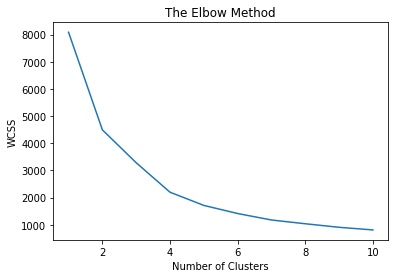

In [136]:
# WCSS: within-cluster-sum-of-square
from sklearn.cluster import KMeans
# start a for loop to run kmeans algorithm for up to 10 clusters

## 1. create a  blank list of different wcss 
wcss = []
## 2. create the first Kmeans object
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state= 0).fit(X)
    wcss.append(kmeans.inertia_)

## 3. To plot the graph
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## The optimum number of cluster, according to the graph, is 4

## Training the K-Means model on the dataset

In [137]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0)
kmeans.fit(X)
# The value of the dependent variables will be ranging from 1 to 4

y_kmeans = kmeans.fit_predict(X)

In [138]:
y_kmeans 

array([0, 2, 0, ..., 0, 2, 0], dtype=int32)

## Visualising the clusters

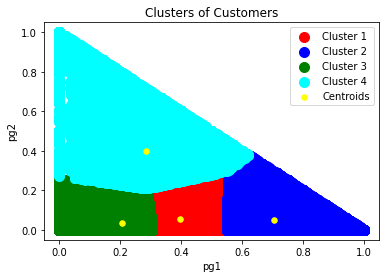

In [139]:
# plot annual income against spending score of the customer clusters
plt.scatter(X[y_kmeans == 0, 0],X[y_kmeans == 0, 1], s = 100, color ='r', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1,0],X[y_kmeans == 1, 1], s = 100, color ='blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2,0],X[y_kmeans == 2, 1], s = 100, color ='green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3,0],X[y_kmeans == 3, 1], s = 100, color ='cyan', label = 'Cluster 4')

# cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0],kmeans.cluster_centers_[:, 1], s = 30, c = 'yellow', label = 'Centroids')

plt.title('Clusters of Customers')
plt.xlabel('pg1')
plt.ylabel('pg2')
plt.legend()
plt.show()

Visualizing the clusters against two components (pg1, perishables, and pg2, shelf-stable goods in this instance) makes it much easier to identify clusters by their distinctive consumer habits.